# Single Replica TIS

This notebook shows how to run single replica TIS move scheme. This assumes you can load engine, network, and initial sample from a previous calculation.

In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from openpathsampling.visualize import PathTreeBuilder, PathTreeBuilder
from IPython.display import SVG, HTML

def ipynb_visualize(movevis):
    """Default settings to show a movevis in an ipynb."""
    view = movevis.renderer
    view.zoom = 1.5
    view.scale_y = 18
    view.scale_th = 20
    view.font_size = 0.4
    return view

Open the storage and load things from it.

In [3]:
#old_store = paths.AnalysisStorage("mstis.nc")
old_store = paths.Storage("mstis.nc")  # if not actually doing analysis, but loading network, etc

In [4]:
network = old_store.networks[0]
engine = old_store.engines[0]
template = old_store.snapshots[0]

In [5]:
network.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
network.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
#rate = network.rate_matrix(old_store.steps)

One of the points of SRTIS is that we use a bias (which comes from an estimate of the crossing probability) in order to improve our sampling.

In [6]:
# this is the normal way you'd get this table
#table = {}
#for t in network.sampling_transitions:
#    for ens, lambda_ens in zip(t.ensembles, [0.04, 0.09, 0.15]):
#        table[ens] = t.tcp(lambda_ens)
#for ens in network.special_ensembles['ms_outer'].keys():
#    table[ens] = 0.0
#    for t in network.sampling_transitions:
#        table[ens] += t.tcp(0.25)
#    table[ens] *= len(network.special_ensembles['ms_outer'].keys())
#    # TODO: Justify the math behind that. Also, run it a bunch more times.
    
# However, we usually have a short (bad statistics) run in "mstis.nc"
# Here are results that I got from a 10k MC step run
#desired_table = {
#    "Out A 0" : 1.0,
#    "Out A 1" : 0.13631671445062318,
#    "Out A 2" : 0.024940771341558789,
#    "Out B 0" : 1.0,
#    "Out B 1" : 0.17104343305339545,
#    "Out B 2" : 0.03927673242602249,
#    "Out C 0" : 1.0,
#    "Out C 1" : 0.19353622940592666,
#    "Out C 2" : 0.066440692846493191,
#    "[UnionEnsemble]" : (0.0030508557603910859+0.0087422825961122538+0.017858280680711457)*3
#} # Union is sum of outermost vals for all 3 versions, times the number of versions

# Here are results that I got from a 20k MC step run
desired_table = {
    "Out A 0" : 1.0,
    "Out A 1" : 0.13293104100673198,
    "Out A 2" : 0.044370838092911397,
    "Out B 0" : 1.0,
    "Out B 1" : 0.13846029208307947,
    "Out B 2" : 0.042622152070289694,
    "Out C 0" : 1.0,
    "Out C 1" : 0.19485705066078274,
    "Out C 2" : 0.053373003923696649,
    "[UnionEnsemble]" : (0.021975696374764188 + 0.021955804935886884 + 0.029175949467020165) / 3
} # Union is average of all 3 version, divided by the number of possible initial states (assuming equal prob)


# now we'll set `table` based on `desired_table`
table = {}
my_ensembles = network.sampling_ensembles + network.special_ensembles['ms_outer'].keys()
for ens in my_ensembles:
    table[ens] = desired_table[ens.name]

In [7]:
bias = paths.BiasEnsembleTable(table)

Here we actually set up the SRTIS move scheme for the given network. It only requires one line:

In [8]:
scheme = paths.SRTISScheme(network, bias=bias, engine=engine)

Now we'll visualize the SRTIS move scheme.

In [9]:
movevis = paths.visualize.MoveTreeBuilder()
#movevis.mover(scheme.move_decision_tree(), network.all_ensembles)
#SVG(ipynb_visualize(movevis).to_svg())

Next we need to set up an appropriate single-replica initial sample set. We'll take the last version of from one of the outer TIS ensembles.

In [10]:
final_samp0 = old_store.steps[len(old_store.steps)-1].active[network.sampling_ensembles[-1]]

In [11]:
sset = paths.SampleSet([final_samp0])

Finally, we set up the new storage file and the new simulation. 

In [12]:
storage = paths.Storage("srtis.nc", "w", template)

In [13]:
srtis = paths.PathSampling(
    storage=storage,
    globalstate=sset,
    move_scheme=scheme
)

In [14]:
n_steps_to_run = int(scheme.n_steps_for_trials(
        mover=scheme.movers['minus'][0], 
        n_attempts=1
    ))
print n_steps_to_run

1230


In [15]:
# logging creates ops_output.log file with details of what the calculation is doing
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [16]:
%%time
multiplier = 100
srtis.run_until(multiplier*n_steps_to_run)

Working on Monte Carlo cycle number 123000.
DONE! Completed 123000 Monte Carlo cycles.
CPU times: user 1h 6min 3s, sys: 4min 10s, total: 1h 10min 13s
Wall time: 1h 8min 42s


In [17]:
storage.close()

From here, we'll be doing the analysis of the SRTIS run.

In [19]:
%%time
storage = paths.AnalysisStorage("srtis.nc")
scheme = storage.schemes[0]

CPU times: user 23min 10s, sys: 36.9 s, total: 23min 47s
Wall time: 29min 44s


In [20]:
scheme.move_summary(storage.steps)

ms_outer_shooting ran 20.818% (expected 0.41%) of the cycles with acceptance 2026/2840 (71.34%)
repex ran 43.850% (expected 3.66%) of the cycles with acceptance 770/5982 (12.87%)
shooting ran 16.112% (expected 3.66%) of the cycles with acceptance 1638/2198 (74.52%)
minus ran 1.129% (expected 0.24%) of the cycles with acceptance 147/154 (95.45%)
pathreversal ran 18.091% (expected 2.03%) of the cycles with acceptance 2275/2468 (92.18%)


In [21]:
scheme.move_summary(storage.steps, 'shooting')

OneWayShootingMover Out A 0 ran 4.369% (expected 0.41%) of the cycles with acceptance 496/596 (83.22%)
OneWayShootingMover Out B 0 ran 0.029% (expected 0.41%) of the cycles with acceptance 3/4 (75.00%)
OneWayShootingMover Out B 1 ran 0.389% (expected 0.41%) of the cycles with acceptance 42/53 (79.25%)
OneWayShootingMover Out A 1 ran 2.258% (expected 0.41%) of the cycles with acceptance 241/308 (78.25%)
OneWayShootingMover Out B 2 ran 1.305% (expected 0.41%) of the cycles with acceptance 111/178 (62.36%)
OneWayShootingMover Out C 1 ran 1.481% (expected 0.41%) of the cycles with acceptance 153/202 (75.74%)
OneWayShootingMover Out C 2 ran 3.519% (expected 0.41%) of the cycles with acceptance 331/480 (68.96%)
OneWayShootingMover Out C 0 ran 0.579% (expected 0.41%) of the cycles with acceptance 71/79 (89.87%)
OneWayShootingMover Out A 2 ran 2.184% (expected 0.41%) of the cycles with acceptance 190/298 (63.76%)


In [22]:
scheme.move_summary(storage.steps, 'minus')

SingleReplicaMinus ran 1.048% (expected 0.08%) of the cycles with acceptance 137/143 (95.80%)
SingleReplicaMinus ran 0.073% (expected 0.08%) of the cycles with acceptance 10/10 (100.00%)
SingleReplicaMinus ran 0.007% (expected 0.08%) of the cycles with acceptance 0/1 (0.00%)


In [23]:
scheme.move_summary(storage.steps, 'repex')

EnsembleHop Out C 2->Out C 1 ran 1.613% (expected 0.20%) of the cycles with acceptance 43/220 (19.55%)
EnsembleHop Out A 2->[UnionEnsemble] ran 1.012% (expected 0.20%) of the cycles with acceptance 72/138 (52.17%)
EnsembleHop Out B 2->[UnionEnsemble] ran 0.667% (expected 0.20%) of the cycles with acceptance 65/91 (71.43%)
EnsembleHop Out B 0->Out B 1 ran 0.066% (expected 0.20%) of the cycles with acceptance 9/9 (100.00%)
EnsembleHop Out B 1->Out B 2 ran 0.198% (expected 0.20%) of the cycles with acceptance 26/27 (96.30%)
EnsembleHop [UnionEnsemble]->Out C 2 ran 9.940% (expected 0.20%) of the cycles with acceptance 87/1356 (6.42%)
EnsembleHop [UnionEnsemble]->Out B 2 ran 9.940% (expected 0.20%) of the cycles with acceptance 66/1356 (4.87%)
EnsembleHop [UnionEnsemble]->Out A 2 ran 10.607% (expected 0.20%) of the cycles with acceptance 71/1447 (4.91%)
EnsembleHop Out C 1->Out C 0 ran 0.748% (expected 0.20%) of the cycles with acceptance 20/102 (19.61%)
EnsembleHop Out A 1->Out A 2 ran 1.1

In [24]:
scheme.move_summary(storage.steps, 'pathreversal')

PathReversal ran 0.667% (expected 0.20%) of the cycles with acceptance 84/91 (92.31%)
PathReversal ran 1.657% (expected 0.20%) of the cycles with acceptance 168/226 (74.34%)
PathReversal ran 1.144% (expected 0.20%) of the cycles with acceptance 144/156 (92.31%)
PathReversal ran 2.104% (expected 0.20%) of the cycles with acceptance 286/287 (99.65%)
PathReversal ran 0.029% (expected 0.20%) of the cycles with acceptance 1/4 (25.00%)
PathReversal ran 0.242% (expected 0.20%) of the cycles with acceptance 17/33 (51.52%)
PathReversal ran 0.982% (expected 0.20%) of the cycles with acceptance 86/134 (64.18%)
PathReversal ran 0.740% (expected 0.20%) of the cycles with acceptance 59/101 (58.42%)
PathReversal ran 0.279% (expected 0.20%) of the cycles with acceptance 32/38 (84.21%)
PathReversal ran 10.248% (expected 0.20%) of the cycles with acceptance 1398/1398 (100.00%)


In [25]:
replica = storage.samplesets[0].samples[0].replica
ensemble_trace = paths.trace_ensembles_for_replica(replica, storage.steps)
print len(ensemble_trace)

123001


In [26]:
repex_acceptance = {}
for mover in scheme.movers['repex']:
    acceptance = [scheme._mover_acceptance[key] for key in scheme._mover_acceptance if key[0] == mover]
    repex_acceptance[mover] = acceptance[0]

scheme.build_balance_partners()
tagged_movers = []
for mover in repex_acceptance:
    if mover in tagged_movers:
        break
    name = mover.name
    acceptance = repex_acceptance[mover]
    acc = float(acceptance[0])/acceptance[1]
    bp_acceptance = repex_acceptance[scheme.balance_partners[mover][0]]
    bp_acc = float(bp_acceptance[0])/bp_acceptance[1]
    in_name = mover.input_ensembles[0].name
    out_name = mover.output_ensembles[0].name
    if (desired_table[out_name] > desired_table[in_name]):
        foo = in_name
        in_name = out_name
        out_name = foo
        foo = acc
        acc = bp_acc
        bp_acc = foo
        
    out_over_in = desired_table[out_name] / desired_table[in_name]
    in_over_out = desired_table[in_name] / desired_table[out_name]

    if (in_name, out_name) not in tagged_movers:
        print "{:.1%} {:.1%} {:.1%} {:s}".format(acc, bp_acc, out_over_in, in_name + "->" + out_name)
    tagged_movers += [(in_name, out_name)]
    

43.0% 19.5% 27.4% Out C 1->Out C 2
52.2% 4.9% 18.3% Out A 2->[UnionEnsemble]
71.4% 4.9% 19.1% Out B 2->[UnionEnsemble]
100.0% 25.7% 13.8% Out B 0->Out B 1
96.3% 26.5% 30.8% Out B 1->Out B 2
44.4% 6.4% 15.2% Out C 2->[UnionEnsemble]
46.5% 19.6% 19.5% Out C 0->Out C 1
22.7% 23.8% 33.4% Out A 1->Out A 2
9.4% 17.0% 13.3% Out A 0->Out A 1


In [27]:
srtis_ensembles = scheme.network.sampling_ensembles+scheme.network.special_ensembles['ms_outer'].keys()
srtis_ensemble_numbers = {e : srtis_ensembles.index(e) for e in srtis_ensembles}
# this next is just for pretty printing
srtis_numbers_ensemble = {srtis_ensemble_numbers[e] : e for e in srtis_ensemble_numbers}
for k in sorted(srtis_numbers_ensemble.keys()):
    print k, ":", srtis_numbers_ensemble[k].name

0 : Out B 0
1 : Out B 1
2 : Out B 2
3 : Out C 0
4 : Out C 1
5 : Out C 2
6 : Out A 0
7 : Out A 1
8 : Out A 2
9 : [UnionEnsemble]


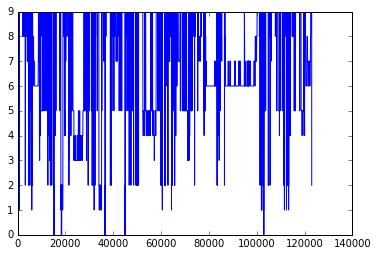

In [28]:
plt.plot([srtis_ensemble_numbers[e] for e in ensemble_trace])

In [29]:
count = 0
for i in range(len(ensemble_trace)-1):
    [this_val, next_val] = [srtis_ensemble_numbers[ensemble_trace[k]] for k in [i,i+1]]
    if this_val == 1 and next_val == 0:
        count += 1
count

9

In [30]:
hist_numbers = [srtis_ensemble_numbers[e] for e in ensemble_trace]
bins = [i-0.5 for i in range(len(srtis_ensembles)+1)]

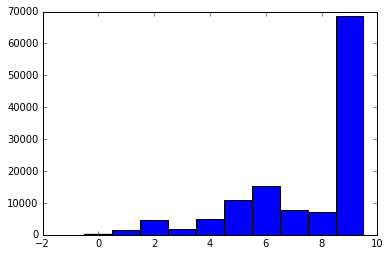

In [31]:
plt.hist(hist_numbers, bins=bins);

In [32]:
import pandas as pd
hist = paths.analysis.Histogram(bin_width=1.0, bin_range=[-0.5,9.5])
colnames = {i : srtis_numbers_ensemble[i].name for i in range(len(srtis_ensembles))}
df = pd.DataFrame(columns=[colnames[i] for i in colnames])

In [33]:
for i in range(len(hist_numbers)):
    hist.add_data_to_histogram([hist_numbers[i]])
    if i % 100 == 0:
        normalized = hist.normalized()
        local_df = pd.DataFrame([normalized.values()], index=[i], columns=[colnames[k] for k in normalized.keys()])
        df = df.append(local_df)

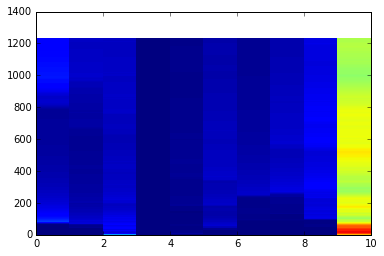

In [34]:
plt.pcolormesh(df.fillna(0.0));